# Model Training, Testing and Evaluation

In [1]:
#import libraries
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import nltk
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report, average_precision_score, auc
from mlxtend.plotting import plot_confusion_matrix
from sklearn.svm import LinearSVC

In [2]:
os.chdir('C:\\Users\\Sean\\Desktop\excel_data')

In [3]:
df = pd.read_csv("clean_df_vader.csv")

In [4]:
vader_score = []

for i in df.sentiment_vader:
    if i <= 0:
        score = 0
    else:
        score = 1
    vader_score.append(score)

df["vader_score"] = vader_score
df.head()

,Unnamed: 0,date,drug_name,condition,rating,comment,final_clean,sentiment_vader,vader_score
0,0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely ha...",sorry say drug abacavir definitely bad unpleas...,-0.9136,0
1,1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together w...",take combo month together rezolsta feel nausea...,-0.5106,0
2,2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 200...",wife epzicom since along viramune work no side...,-0.1027,0
3,3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination...",epzicom reyataz norvir triple combination expe...,0.2732,1
4,4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and star...",use since first diagnose start haart work extr...,0.4536,1


In [5]:
svm_data = pd.DataFrame({"final_clean" : df["final_clean"], "vader_score" : df["vader_score"]})
train, test = train_test_split(svm_data, test_size=0.3, random_state=101)

In [6]:
vader_train_1 = train[train['vader_score']==0]
vader_train_2 = train[train['vader_score']==1]

print("shape for vader_train_1: " + str(vader_train_1.shape))
print("shape for vader_train_2: " + str(vader_train_2.shape))

shape for vader_train_1: (49676, 2)
shape for vader_train_2: (38370, 2)


In [7]:
vader_train_1 = train[train['vader_score']==0].sample(45000,replace=True, random_state=53)
vader_train_2 = train[train['vader_score']==1].sample(45000,replace=True, random_state=53)

vader_training_bs = pd.concat([vader_train_1, vader_train_2])

print("training dataset shape: " + str(train.shape))
print("testing dataset shape: " + str(test.shape))
print("vader_training_bs shape: " + str(vader_training_bs.shape))

training dataset shape: (88046, 2)
testing dataset shape: (37734, 2)
vader_training_bs shape: (90000, 2)


In [8]:
train['vader_score'].value_counts(normalize=True)
vader_training_bs['vader_score'].value_counts(normalize=True)

1    0.5
0    0.5
Name: vader_score, dtype: float64

In [9]:
Train_X = vader_training_bs["final_clean"]
Train_Y = vader_training_bs["vader_score"]
Test_X = test["final_clean"]
Test_Y = test["vader_score"]

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [10]:
SVM = LinearSVC(random_state=1)

In [11]:
def tf_vec_ngram(params, X_train, y_train):
    tfvec_p = TfidfVectorizer(ngram_range=(params))
    tfvec_p.fit(X_train.astype(str))
    X_train_tfvec_p = tfvec_p.transform(X_train.astype(str))
    tfvec_score_p = cross_val_score(SVM, X_train_tfvec_p, y_train, cv=10)
    return tfvec_score_p.mean()

params = [(1,1), (1,2), (1,3)] 

ngram_scores = []

for p in params:
    ngram_scores.append(tf_vec_ngram(p, Train_X, Train_Y)*100)
    
ngrams = ['n_gram_(1,1)','n_gram_(1,2)','n_gram_(1,3)']
ngram_df = pd.DataFrame({'params':ngrams, 'scores':ngram_scores}, index=[0,1,2])

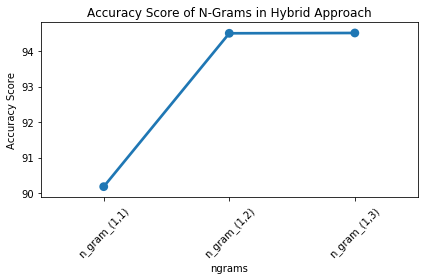

In [12]:
# plot scores on graph
sns.pointplot(x='params', y='scores', data=ngram_df)
plt.ylabel('Accuracy Score')
plt.xlabel('ngrams')
plt.title('Accuracy Score of N-Grams in Hybrid Approach')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('SVM ngram accuracy.png')

In [12]:
ngram_df

,params,scores
0,"n_gram_(1,1)",90.181111
1,"n_gram_(1,2)",94.502222
2,"n_gram_(1,3)",94.511111


In [13]:
def tf_vec_max_features(params, Train_X, Train_Y):
    tfvec_p = TfidfVectorizer(max_features=params)
    tfvec_p.fit(Train_X.astype(str))
    Train_X_tfvec_p = tfvec_p.transform(Train_X.values.astype(str))
    tfvec_score_p = cross_val_score(SVM, Train_X_tfvec_p, Train_Y, cv=10)
    return tfvec_score_p.mean()

max_features_params = [None, 1000, 5000, 10000, 20000]

max_features_scores = [tf_vec_max_features(p, Train_X, Train_Y) for p in max_features_params]

max_features = ['max_f_' + str(p) for p in max_features_params]

max_features_df = pd.DataFrame({'params':max_features, 'scores':max_features_scores}, index=[0,1,2,3,4])
max_features_df.scores = max_features_df.scores*100

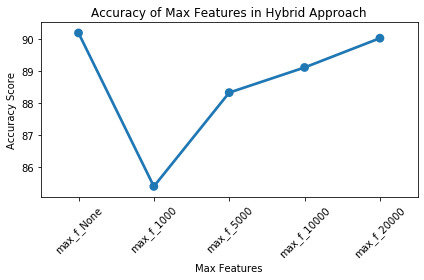

In [15]:
sns.pointplot(x='params', y='scores', data =max_features_df)
plt.ylabel('Accuracy Score')
plt.xlabel('Max Features')
plt.xticks(rotation=45)
plt.title('Accuracy of Max Features in Hybrid Approach')
#plt.show()
plt.tight_layout()
plt.savefig('SVM Max_features.png')

In [14]:
max_features_df

,params,scores
0,max_f_None,90.181111
1,max_f_1000,85.393333
2,max_f_5000,88.320000
3,max_f_10000,89.104444
4,max_f_20000,90.017778


In [15]:
def tf_vec_max_df(params, Train_X, Train_Y):
    tfvec_p = TfidfVectorizer(max_df=params)
    tfvec_p.fit(Train_X.astype(str))
    X_train_tfvec_p = tfvec_p.transform(Train_X.astype(str))
    tfvec_score_p = cross_val_score(SVM, X_train_tfvec_p, Train_Y, cv=10)
    return tfvec_score_p.mean()

max_df_params = [0.25, 0.5, 0.75, 1.0]
max_df_scores = [tf_vec_max_df(p, Train_X, Train_Y) for p in max_df_params]
max_df = ['max_df_'+str(p) for p in max_df_params]

max_df_df = pd.DataFrame({'params':max_df, 'scores':max_df_scores}, index=[0,1,2,3])
max_df_df.scores = max_df_df.scores*100

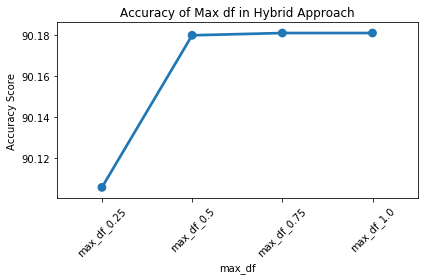

In [18]:
sns.pointplot(x='params', y='scores', data =max_df_df)
plt.ylabel('Accuracy Score')
plt.xlabel('max_df')
plt.xticks(rotation=45)
plt.title('Accuracy of Max df in Hybrid Approach')
plt.tight_layout()
plt.savefig('SVM max_df accuracy.png')

In [16]:
max_df_df

,params,scores
0,max_df_0.25,90.105556
1,max_df_0.5,90.180000
2,max_df_0.75,90.181111
3,max_df_1.0,90.181111


In [17]:
def tf_vec_min_df(params, Train_X, Train_Y):
    tfvec_p = TfidfVectorizer(min_df=params)
    tfvec_p.fit(Train_X.astype(str))
    X_train_tfvec_p = tfvec_p.transform(Train_X.astype(str))
    tfvec_score_p = cross_val_score(SVM, X_train_tfvec_p, Train_Y, cv=10)
    return tfvec_score_p.mean()

min_df_params = [1, 100, 1000, 5000, 10000]
min_df_scores = [tf_vec_min_df(p, Train_X, Train_Y) for p in min_df_params]
min_df = ['min_df_'+str(p) for p in min_df_params]

min_df_df = pd.DataFrame({'params':min_df, 'scores':min_df_scores}, index=[0,1,2,3,4])
min_df_df.scores = min_df_df.scores*100

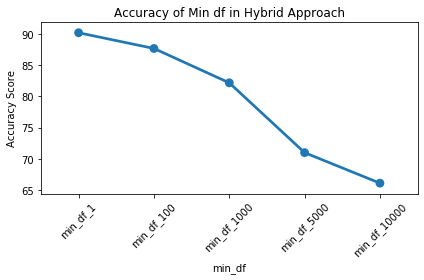

In [21]:
sns.pointplot(x='params', y='scores', data =min_df_df)
plt.ylabel('Accuracy Score')
plt.xlabel('min_df')
plt.xticks(rotation=45)
plt.title('Accuracy of Min df in Hybrid Approach')
plt.tight_layout()
plt.savefig('SVM min_df accuracy.png')

In [18]:
min_df_df

,params,scores
0,min_df_1,90.181111
1,min_df_100,87.666667
2,min_df_1000,82.166667
3,min_df_5000,70.996667
4,min_df_10000,66.112222


In [19]:
SVM = LinearSVC(random_state=0, loss="hinge")

ngram_list = [(1,1), (1,2), (1,3)]

score_list =[]

for i in ngram_list:
    tfvec_b = TfidfVectorizer(ngram_range=i, max_df=0.5)
    
    # fit training data on model
    tfvec_b.fit(Train_X.astype(str))
    
    #transform training data into matrix
    X_train_cvec = tfvec_b.transform(Train_X.astype(str))

    sv_params = {'C':[0.1, 1],
                 'intercept_scaling':[1, 100, 500]}

    # gridsearchCV
    svm_grid = GridSearchCV(SVM, param_grid=sv_params, cv=10, n_jobs=-1, verbose=1)

    # fit with the tranformed matrix
    svm_grid.fit(X_train_cvec, Train_Y)

    print('Best Score for: ' + str(i) + " is " + str(svm_grid.best_score_))

    # assign the best estimator
    best_svm = svm_grid.best_estimator_
    print('Best Params for: ' + str(i) + " is " + str(svm_grid.best_params_))
    
    score_list.append(svm_grid.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.5min finished


Best Score for: (1, 1) is 0.8944777777777778
Best Params for: (1, 1) is {'C': 1, 'intercept_scaling': 1}
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 38.6min finished


Best Score for: (1, 2) is 0.9396333333333333
Best Params for: (1, 2) is {'C': 1, 'intercept_scaling': 1}
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 60.2min finished


Best Score for: (1, 3) is 0.9431777777777778
Best Params for: (1, 3) is {'C': 1, 'intercept_scaling': 1}


In [20]:
ngram_df = pd.DataFrame({"n_gram": ngram_list, "score":score_list})
ngram_df.to_csv("ngram_score_vader.csv")

In [21]:
#fit in best parameters
tfvec_b = TfidfVectorizer(ngram_range=(1,3), max_df=0.5)

# fit the training data
tfvec_b.fit(Train_X.astype(str))

#transform training data into matrix
X_train_cvec = tfvec_b.transform(Train_X.astype(str))

sv_params = {'C':[1], 'intercept_scaling':[1]}

# gridsearchCV
svm_grid = GridSearchCV(SVM, param_grid=sv_params, cv=10, n_jobs=-1, verbose=1)

# fit with the tranformed matrix
svm_grid.fit(X_train_cvec, Train_Y)

best_svm = svm_grid.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


In [22]:
SVM = LinearSVC(random_state=0, loss="hinge", C=1, intercept_scaling=1)

test_tfidf = TfidfVectorizer(ngram_range=(1,3), max_df=0.5)
test_tfidf.fit(Test_X)
X_test_cvec = tfvec_b.transform(Test_X)

# Train model
SVM.fit(X_train_cvec, Train_Y)

# predictions of testing data.
y_pred = SVM.predict(X_test_cvec)

# Compare predicted y to actual y
accuracy = (y_pred == Test_Y).mean()

print(accuracy)

0.8591455981343086


In [24]:
from sklearn.externals import joblib
joblib.dump(SVM, 'svm_model.pkl') 

['svm_model.pkl']

In [27]:
cm_cv = confusion_matrix(Test_Y, y_pred)

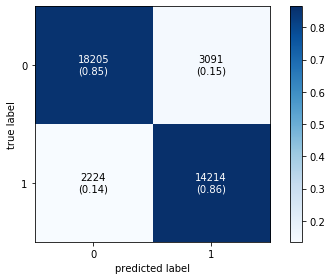

In [28]:
fig,ax = plot_confusion_matrix(cm_cv, show_normed=True, colorbar=True, show_absolute=True)
plt.tight_layout()
plt.savefig('confusion_matrix_VADER.png')

In [29]:
print(classification_report(Test_Y, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     21296
           1       0.82      0.86      0.84     16438

    accuracy                           0.86     37734
   macro avg       0.86      0.86      0.86     37734
weighted avg       0.86      0.86      0.86     37734



In [30]:
report = classification_report(Test_Y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.891135,0.854855,0.872618,21296.000000
1,0.821381,0.864704,0.842486,16438.000000
accuracy,0.859146,0.859146,0.859146,0.859146
macro avg,0.856258,0.859780,0.857552,37734.000000
weighted avg,0.860748,0.859146,0.859492,37734.000000


In [31]:
report_df.to_csv("classication_report_svm_vader.csv")